In [1]:
import sys
sys.path.insert(0, "..")

%load_ext autoreload
%autoreload 2

In [10]:
from jax.config import config

config.update("jax_debug_nans", True)
from jaxgp.config import Config
import jax
import jaxgp as jgp
import jax.numpy as jnp
import jax.random as jr
from jaxgp.sgpr import SGPR
from scipy.optimize import minimize
import jaxopt
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# N = 50000
# noise = 0.2
rng = np.random.RandomState(123)

# N = 10000  # Number of training observations
# def func(x):
#     return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

# X = rng.rand(N, 1) * 2 - 1  # X values
# y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
# data = (X, y)
# M = 50
# Z = X[:M, :].copy()
# Xtest = np.linspace(-1.,  1., 500).reshape(-1, 1)
# ytest = func(Xtest)

def readCsvFile(fileName):
    return np.loadtxt(fileName).reshape(-1, 1)

def getTrainingTestData():
    overallX = readCsvFile("data/snelson_train_inputs.dat")
    overallY = readCsvFile("data/snelson_train_outputs.dat")

    trainIndices = []
    testIndices = []

    nPoints = overallX.shape[0]

    for index in range(nPoints):
        if index % 4 == 0:
            trainIndices.append(index)
        else:
            testIndices.append(index)

    Xtrain = overallX[trainIndices, :]
    Xtest = overallX[testIndices, :]
    Ytrain = overallY[trainIndices, :]
    Ytest = overallY[testIndices, :]

    return Xtrain, Ytrain, Xtest, Ytest

X, y, Xtest, ytest = getTrainingTestData()
Z = X.copy()


In [48]:
train_data = jgp.Dataset(X=X, Y=y)
kernel = jgp.RBF(active_dims=[0])
model = SGPR(
    train_data=train_data,
    gprior=jgp.GPrior(kernel=kernel),
    likelihood=jgp.Gaussian(num_datapoints=train_data.N),
    inducing_points=Z,
)
params, constrain_trans, unconstrain_trans = jgp.initialise(model)
posterior = model.posterior()

# params.keys()

In [49]:
# Copy dictionary structure
import copy
prior_container = copy.deepcopy(params)
# Set all values to zero
prior_container = jax.tree_map(lambda v: v.shape, prior_container)
print(prior_container)

{'inducing_points': (50, 1), 'kernel': {'lengthscale': (1,), 'outputscale': (1,)}, 'likelihood': {'noise': ()}, 'mean_function': {}}


In [51]:
final_params = copy.deepcopy(params)
final_params["inducing_points"] = Z
final_params["kernel"]["lengthscale"] = 0.5825
final_params["kernel"]["outputscale"] = 0.90049
final_params["likelihood"]["noise"] = 0.074286

pred_mean, pred_var = posterior.predict_f(
    Xtest, final_params, full_cov=False
)

In [44]:
train_data = jgp.Dataset(X=X, Y=y)
kernel = jgp.RBF(active_dims=jnp.arange(X.shape[-1]))
model = SGPR(
    train_data=train_data,
    gprior=jgp.GPrior(kernel=kernel),
    likelihood=jgp.Gaussian(num_datapoints=train_data.N),
    inducing_points=Z,
)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(sign=-1.0)
print("Initial negative elbo = ", neg_elbo(raw_params))
solver = jaxopt.ScipyMinimize(
    fun=neg_elbo, jit=True, options={"disp": True}
)
soln = solver.run(raw_params)
print("After optimization negative elbo = ", soln.state.fun_val)
# Remember to transform since the optimization is in unconstrained space
final_params = constrain_trans(soln.params)
posterior = model.posterior()

Initial negative elbo =  56.21773315689732
         Current function value: -88.601344
         Iterations: 61
         Function evaluations: 297
         Gradient evaluations: 285
After optimization negative elbo =  -88.60134399256194


In [45]:
pred_mean, pred_var = posterior.predict_f(
    Xtest, final_params, full_cov=False
)

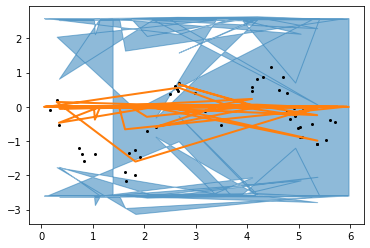

In [46]:
plt.plot(X, y, "o", color="k", markersize=2)
# plt.plot(final_params["inducing_points"], np.zeros_like(Z), "x", color="tab:red")
plt.plot(Xtest, pred_mean, color="tab:orange", linewidth=2)
plt.fill_between(
    Xtest.squeeze(),
    pred_mean.squeeze() - 2*np.sqrt(pred_var.squeeze()),
    pred_mean.squeeze() + 2*np.sqrt(pred_var.squeeze()),
    alpha=0.5,
    color="tab:blue",
)

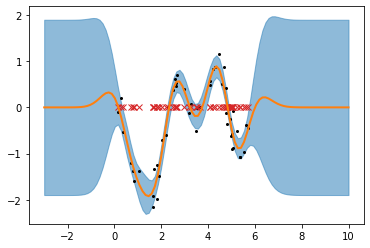

In [53]:
Xtest = jnp.linspace(-3, 10, 100)
pred_mean, pred_var = posterior.predict_f(
    Xtest, final_params, full_cov=False
)
plt.plot(X, y, "o", color="k", markersize=2)
plt.plot(final_params["inducing_points"], np.zeros_like(Z), "x", color="tab:red")
plt.plot(Xtest, pred_mean, color="tab:orange", linewidth=2)
plt.fill_between(
    Xtest.squeeze(),
    pred_mean.squeeze() - 2*np.sqrt(pred_var.squeeze()),
    pred_mean.squeeze() + 2*np.sqrt(pred_var.squeeze()),
    alpha=0.5,
    color="tab:blue",
)

In [ ]:
qu_mean, qu_cov = model.compute_qu(final_params)
f_at_Z_mean, f_at_Z_cov = posterior.predict_f(
    final_params["inducing_points"], final_params, full_cov=True
)

In [ ]:
assert jnp.allclose(qu_mean, f_at_Z_mean, rtol=1e-5, atol=1e-4)
assert jnp.allclose(
    qu_cov.reshape(1, 20, 20), f_at_Z_cov, rtol=1e-5, atol=1e-5
)